<div style='width:500px; height:220px; border-bottom:10px black solid;border-left: 10px green solid;padding: 10px 10px 10px 10px;'>
    <h1> ---Portofolio Optimization Plot---</h1>
    <h3> Author: Jakob Lindstrøm </h3>
    <h3> Date: 03.05.2023 </h3>
</div>

<div style='width:600px; height:800px; padding: 10px 10px 10px 10px;border-bottom:10px black solid;
            border-left: 10px green solid'>
    <div>
        <h4>Keywords:</h4>
        <p> Stocks, portfolio, optimization, finance </p>
        <h4> Data sources:  </h4>
        <p> yfinance: https://pypi.org/project/yfinance/ </p>
        <p> DNB markets: https://www.dnb.no/bedrift/markets/analyser/arkiv/anbefalteaksjer.html </p>
        <h4> Intention: </h4>
        <p> This programe has the goal of finding the optimal weigths for a given amount of stocks in a portofolio. The programe uses live-data from the python library yfinance to collect stock data. Furthermore the stocks will be modelled in regard to different portfolio weigths. There will be three optimzed portofolios for: minimum variance, highest Sortino ratio and highest Sharpe ratio. You are completely free to choose which stocks to include in the portfolio, I use the weekly recommended stocks from DNB markets. </p>
        <br>
        <p>Furthermore the weight sof one portfolio will be used to create a machine learning model to predict and forecast upcoming values. </p>
        <br>
        <h4> Disclaimer: </h4>
        <p> The author do not take any responsibility for potential consequences thats been a result of using the code below. </p>
    </div>
</div>

<h1> Table of content </h1>
<ol>
<li>Importing libraries</li>
<li>State input and retrieval</li>
<li>Feature engineering</li>
<li>Random portofolios</li>
<li>Optimization on Sharpe and Sortino</li>
<li>Plot over different portofolios</li>
<li>Machine Learning on time series</li>
<ol>
<li>Trend</li>
<li>Cycles</li>
<li>Residuals</li>

</ol>
<li>Forecasting</li>
<li>Summary</li>

</ol>

<em> Possible improvements:
<ol>
<li> Use logaritmic stock returns</li>
<li> Create arandom walk, with a modified distributions in accordance to each stock distributions</li>
<li> Investigate different ML-models for modelling cycles and residuals</li>
<li> Use parameters search Grid / Random / Bayesian in finetuning of the models</li>
<li> Make the time series component analysis more automized.</li>
<li> Come up with new ideas, for example include a modified random walk adjusted to a Cholensky matrix. </li>
<li> ...</li>

</ol></em>

<h1> 1. Importing libraries

In [1571]:
#Importing libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random as rd
import math 
from math import sqrt

import yfinance as yf   
from datetime import datetime

import scipy.stats as st
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_pacf

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

from IPython.display import Image

from sklearn.model_selection import train_test_split

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings("ignore")

<h1> 2. State input and retrieve it </h1>
<p> Below one shall state the input for the programme. Which stocks to include, for how long a time, how many arbitrary portofolios and the length of the forecast period. 

In [1092]:
#INPUT FIELD:   
stocks = ['AKRBP.OL','ATEA.OL','EQNR.OL','EPR.OL','LSG.OL','MOWI.OL','SRBNK.OL','SUBC.OL']
#format: year-month-day
startPor = '2018-01-01'
hold_portofolio_days = 21
portofolio_Distributions = 1000
endDate = datetime.now().strftime('%Y-%m-%d')
#format: year-month-day
# endDate = '2023-01-29'

# Monte Carlo simulation
forecast_period = 40

In [776]:
#Retrieve financial data from yahoo finace


def dataRetriever():
    df = []
    for i in range(0,len(stocks),1):
        yahoo = yf.download(stocks[i], start=startPor, end=endDate)
        data = [0]
        for j in range(0, len(yahoo['Adj Close'])-1,1):
            selecive_data = ((yahoo['Adj Close'][j+1]/yahoo['Adj Close'][j])-1)
            data.append(selecive_data)
        adj_close = yahoo['Adj Close']
        relevant  = [stocks[i], data, adj_close]
        df.append(relevant)
    return df
mystocks = dataRetriever()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


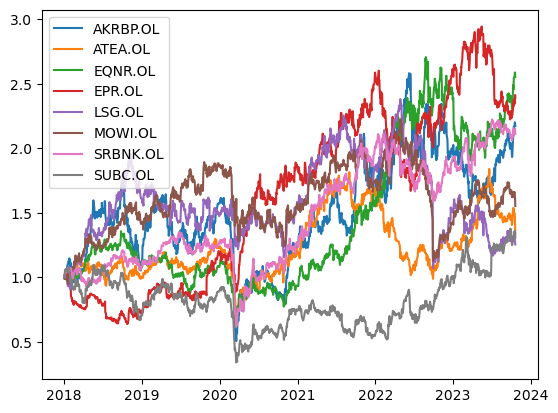

In [777]:
#Plot the past movement for the different stocks


fig, ax = plt.subplots()
for i in range(0,len(mystocks),1):
    ax.plot(mystocks[i][2]/mystocks[i][2][0], label=stocks[i])
plt.legend()
plt.show()

<h1> 3. Feature engineering (ratios, risks and returns) </h1>
<p> This section of the programme will define vital information of the stocks. Covariance matrix, risks and returns.

In [778]:
#Create a ratio for the number of positive moves each stock has
#Add this ratio to the list of stocks


def pos_ratio():
    pos_ratio_list = []
    for i in range(0,len(mystocks),1):
        pos_ratio = np.where(np.array(mystocks[i][1])>0,1,0).sum()/len(mystocks[i][1])
        pos_ratio_list.append(pos_ratio)
    return pos_ratio_list

pos_ratio_stock = pos_ratio()

In [779]:
#Create mean returns for each stock


def means():
    means = []
    for i in range(0,len(mystocks),1):
        means.append(pd.Series(mystocks[i][1]).mean())
    return np.array(means)
mean = means()

def stds():
    means = []
    for i in range(0,len(mystocks),1):
        means.append(pd.Series(mystocks[i][1]).std())
    return np.array(means)
std = stds()

In [780]:
#Create different portofolio risk matrices based 
#on total risk, downside risk and upside risk


total_cov_matrix = pd.DataFrame()
negative_cov_matrix =  pd.DataFrame()
positive_cov_matrix = pd.DataFrame()

for i in range(0, len(mystocks),1):
    total_cov_matrix[mystocks[i][0]] = mystocks[i][1]

    stock = pd.Series(mystocks[i][1])

    neg = stock.loc[stock < 0]
    negative_cov_matrix[mystocks[i][0]] = neg

    pos = stock.loc[stock > 0]
    positive_cov_matrix[mystocks[i][0]] = pos

negative_cov_matrix =  negative_cov_matrix.cov()
total_cov_matrix = total_cov_matrix.cov()
positive_cov_matrix = positive_cov_matrix.cov()

<h1> Random portofolios </h1>
<p> Now a various of portfolios will be generate and information about them will be added into a dataframe.

In [781]:
#Generate random weigths for all stocks in each portofolio n times


def portofolio_generator():
    portofolios = []
    for i in range(0,portofolio_Distributions,1):
        single = np.random.dirichlet(np.ones(len(stocks)),size=1)
        portofolios.append(single)
    return portofolios
portofolios = portofolio_generator()

In [782]:
#Create returns for each portofolio


def portofolioReturns(ps):
    returns = []
    for i in range(0, len(ps),1):
        returns.append(sum(mean@ps[i].T))
    return returns
returns = portofolioReturns(portofolios)

In [783]:
# Generate standard deviation for portofolios
# ps = portofolios, cov = covariance matrix

def portofolio_std(ps, cov):
    #ps is short for portofolios
    pstd = [(ps[i] @ cov @ ps[i].T)**.5 for i in range(len(ps))]
    portofolio_std = pd.Series([pstd[i][0][0] for i in range(len(ps))])

    return portofolio_std



#Calculate the different risktypes for each portofolio
neg_risk = portofolio_std(portofolios, negative_cov_matrix)
tot_risk = portofolio_std(portofolios, total_cov_matrix)
pos_risk = portofolio_std(portofolios, positive_cov_matrix)

In [784]:
#Create a function to predict the ratio of 
#positive moves a portofolio will have


def por_pos_ratio(ps):
    por_pos_ratio = [ps[i][0]@(np.array(pos_ratio_stock)-0.5) 
                     for i in range(len(ps))]

    return por_pos_ratio
por_movement_ratio_dir = por_pos_ratio(portofolios)


In [785]:
#Create a dataframe containing all portofolios
#with a predicted return over 0%


def dfOutput():
    
    df = pd.DataFrame()
    colnames =  ['Weigths', 'Return', 'Total_risk','Negative_risk', 'Positive_risk','Pos_risk_ratio']
    colvalues = [portofolios, returns, tot_risk, neg_risk, pos_risk, por_movement_ratio_dir]
    
    for i in range(0,len(colnames),1):
        df[colnames[i]] = colvalues[i]
    df['Sharpe_Ratio'] = df['Return']/(df['Total_risk'])
    df['Sharpe_Ratio'] = colvalues[1]/(colvalues[2])
    df['Sortino_Ratio'] =df['Return']/(df['Negative_risk']+1)
    df = df.loc[df['Return'] >= 0].reset_index()
    del df['index']

    return df
df = dfOutput()

<h1> Optimzation on Sharpe and Sortino

Now that the feature engineering part is done, one can optimize a portofolio. I have choosen to optimze three portofolios in regard to minimum variance, highest Sortino ratio and highest Sharpe ratio.  

In [786]:
c1 = Bounds(0,1)

#Creating arbitrary values for weigths
c2 = LinearConstraint(np.ones((len(stocks),), dtype=int),1,1)

#Creating arbitrary values for the weigths
weigths = np.ones(len(stocks))
#And making them add up to 100%.
decVar = weigths/np.sum(weigths)


opt_port = []
opt_spec = ['Minimum Variance', 'Highest Sortino', 'Highest Sharpe']
special_params = [total_cov_matrix,negative_cov_matrix,total_cov_matrix]
for i in range(0,3,1):
    if  i ==0:  
        Z = lambda w: np.sqrt(w@special_params[i]@w.T)
    else:
        Z = lambda w: np.sqrt(w@special_params[i]@w.T)/(mean@w)

    res = minimize(Z, decVar, method='trust-constr', constraints = c2, bounds = c1)
    w = res.x
    ret = sum(w*mean)
    risk = (w@total_cov_matrix@w.T)**.5
    opt_port.append([w, ret, risk, opt_spec[i]])


<h1> 6 Plot over different portofolios

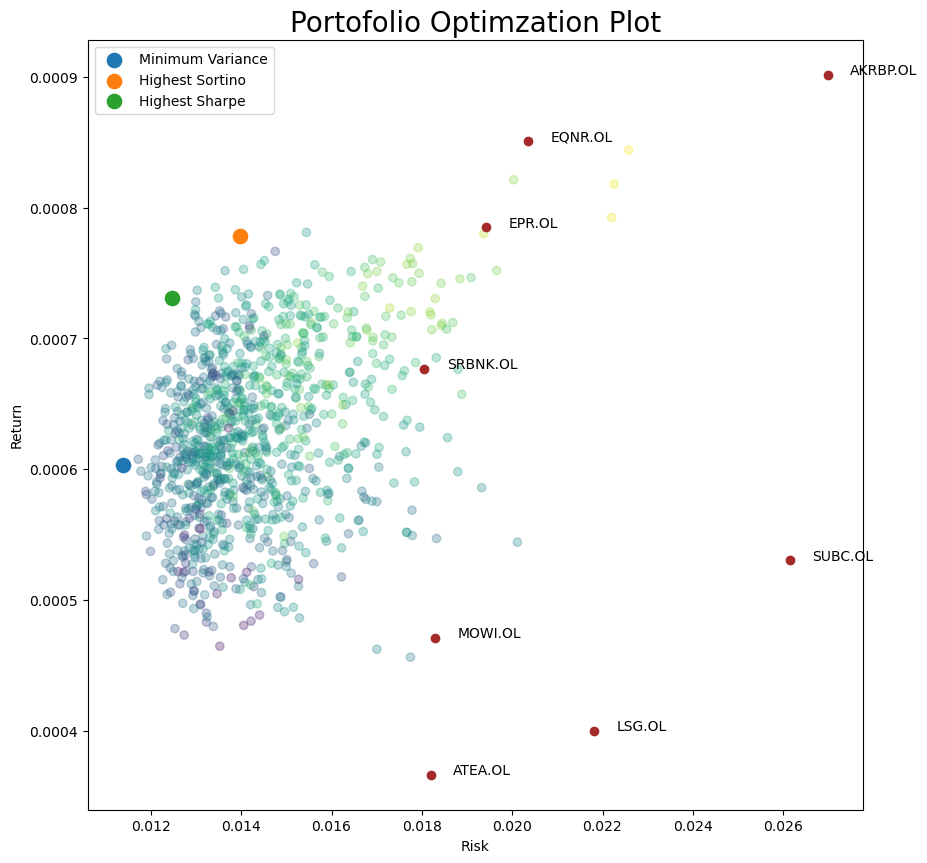

<Figure size 640x480 with 0 Axes>

In [1586]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y=returns, x=tot_risk, c=df['Pos_risk_ratio'],
           marker='o', alpha=.3)

for i in range(3):
    ax.scatter(x=opt_port[i][2],y=opt_port[i][1], label=opt_port[i][3], s=105)

ax.scatter(y=mean, x= std,color='brown')
for i in range(len(stocks)):
    plt.annotate(stocks[i], (std[i]+0.0005,mean[i]))
plt.xlabel('Risk')
plt.ylabel('Return')
plt.legend()
plt.title('Portofolio Optimzation Plot', fontsize=20)
plt.show()
plt.savefig('opt_ex.png')

Looking at the plot above one can see how the risk and returns varies from different weigths in the portofolio. I will personally choose the portofolio with the highest Sharpe ratio, and try to model it.

In [1591]:
# Choosing my portfolio, I choose the highest sharpe ratio
best_por = opt_port[2][0]

<AxesSubplot:>

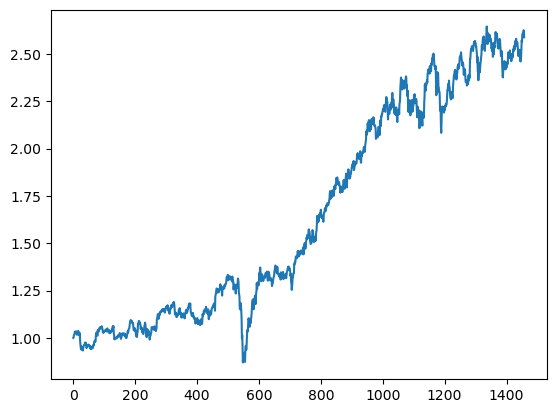

In [1592]:
time_cum = []
for i in range(0, len(mystocks[0][1])):
    day_cum = []
    day_sel = 0

    for j in range(len(best_por)):
        day_sel += best_por[j]*mystocks[j][1][i]
        if j == (len(best_por)-1):
            
            day_cum.append(day_sel+1)
    time_cum.append(day_cum[0])

portofolio_actual_movement = pd.Series(np.cumprod(time_cum))
portofolio_actual_movement.plot()
plt.show()

<h1>7 Machine Learning on time series </h1>
<p> Now I will try to create a ML model that can forecast my choosen portofolio. I will use all the different time series components, except for seasonality. In other words; I will try to capture the trend, cycles and seasonality of the time series. I will use a recursive strategy for forecasting. 

<h2> 7.1 Trend

In [905]:
#Creating X and y ffeature for capturing the trend


y = portofolio_actual_movement.copy()
dp = DeterministicProcess(index=y.index,
                          constant=True,
                          order=2,
                          drop=True)
X = dp.in_sample()


In [1024]:
# Splitting the data into different sets
def tts(X,y):
    idx_train, idx_test = train_test_split(y.index,
                                        test_size=60,
                                        random_state=42,
                                        shuffle=False)
    X_train, y_train = X.loc[idx_train,:], y.loc[idx_train]
    X_test, y_test = X.loc[idx_test,:], y.loc[idx_test]
    return [X_train,y_train, X_test,y_test]

first_split = tts(X, portofolio_actual_movement)
X_train, y_train = first_split[0],first_split[1]
X_test, y_test = first_split[2], first_split[3]

In [1404]:
# Fitting a linear regression model to capture trend
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Predict the train and test set
y_fit_trend = pd.Series(model1.predict(X_train),
                  index=y_train.index)

y_pred_trend = pd.Series(model1.predict(X_test), 
                      index=y_test.index)

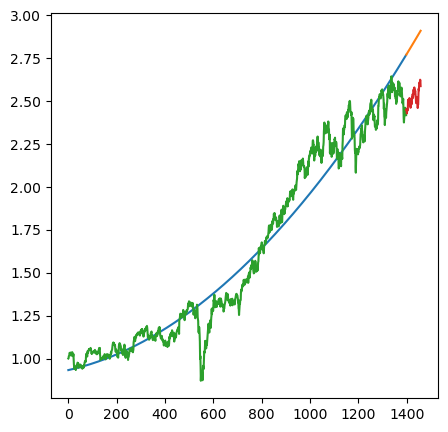

In [1583]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(y_fit_trend)
ax.plot(y_pred_trend)
ax.plot(y_train)
ax.plot(y_test)

<h2> 7.2 Cycles </h2>
<p> This cycle section hasnt been automized yet. Here its important to choosen the number of lagged variables one want. This input shall go in to the "generate_lags" function.

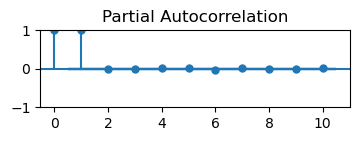

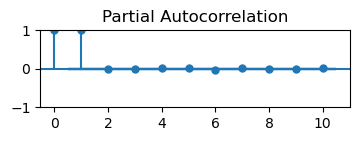

In [1406]:
fig, ax = plt.subplots(figsize=(4,1))
plot_pacf(y, lags=10, ax=ax)

In [1407]:
def generate_lags(data, n_lags):
    df = pd.DataFrame()
    for i in range(1,n_lags+1,1):
        df['lag'+str(i)] = data.shift(i, fill_value=1)
    return df

X_train_cyc = generate_lags(y_train,1)
X_test_cyc = generate_lags(y_test,1)

y_train_cycle = y_train - y_fit_trend


In [1408]:
model2 = RandomForestRegressor(n_estimators=10, max_depth=5)
model2.fit(X_train_cyc, y_train_cycle)

RandomForestRegressor(max_depth=5, n_estimators=10)

In [1409]:
y_fit_cyc = model2.predict(X_train_cyc)
y_pred_cyc = model2.predict(X_test_cyc)

<AxesSubplot:>

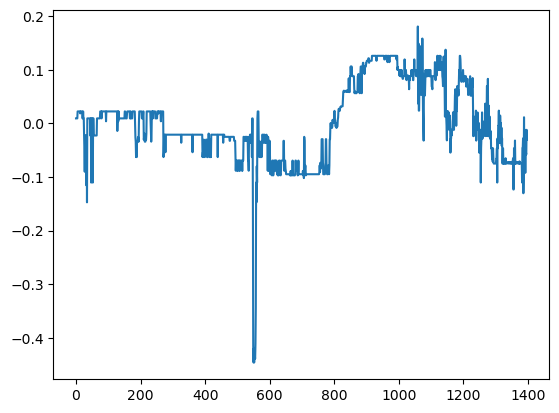

In [1589]:
pd.Series(y_fit_cyc).plot()

<h2> 7.3 Residuals </h2>


In [1594]:
y_train_resid = y_train - y_fit_cyc - y_fit_trend

In [1411]:
X_train_resid = pd.concat([X_train, X_train_cyc],axis=1)
X_test_resid = pd.concat([X_test, X_test_cyc], axis=1)

In [1413]:

model3 = XGBRegressor()
model3.fit(X_train_resid, y_train_resid)

y_fit_resid = model3.predict(X_train_resid)
y_pred_resid = model3.predict(X_test_resid)


<AxesSubplot:>

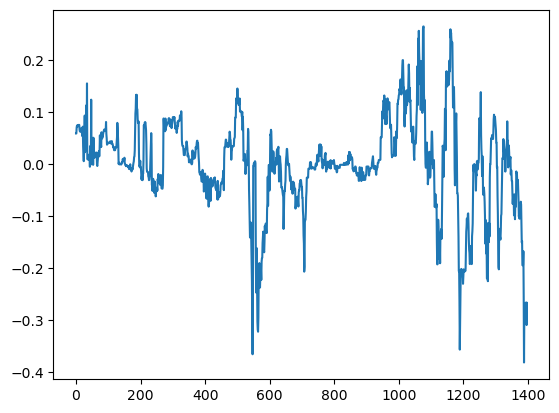

In [1590]:
pd.Series(y_fit_resid).plot()

<h1> 8 Forecasting </h1>
<p> Now I will try to forecast the model based on my previous findings. 

In [ ]:
final_fit  = y_fit_cyc + y_fit_resid +  y_fit_trend
final_pred = y_pred_cyc + y_pred_resid + y_pred_trend

In [1445]:
# Multimodel function for forecasting values


def multi_model(pred):
    new_y1 = model1.predict(pred.loc[:,: 'trend_squared'])
    new_y2 = model2.predict(pred[['lag1']])
    new_y3 = model3.predict(pred)

    new_forecast = new_y1[0] + new_y2[0] + new_y3[0]

    return new_forecast

In [1476]:
# Forecast function that uses a Recursive strategy

def recursive():
    forecast_features = pd.DataFrame(columns= ['const', 'trend', 'trend_squared', 'lag1'], index=[0])
    previous_row = X_test_resid.iloc[-1:].reset_index()
    forecasts = []

    for i in range(0,  40,1):
        if i == 0:
            previous_target = y_test[-1:].reset_index()[0][0]
        else:
            previous_target = forecasts[-1]

        new_row = [1, 
                previous_row['trend'][0]+i,
                (previous_row['trend'][0]+i)**2,
                previous_target]
        new_pred = pd.DataFrame({'const':new_row[0],
                                'trend':new_row[1],
                                'trend_squared':new_row[2],
                                'lag1':new_row[3]}, 
                                index=[0])
        
        forecasts.append(multi_model(new_pred))


        forecast_features.loc[i] = new_row
    
    return [forecasts, forecast_features]


In [1544]:
forecasts = recursive()[0]
for_idx = np.linspace(len(y)+1, len(y)+len(forecasts),forecast_period)

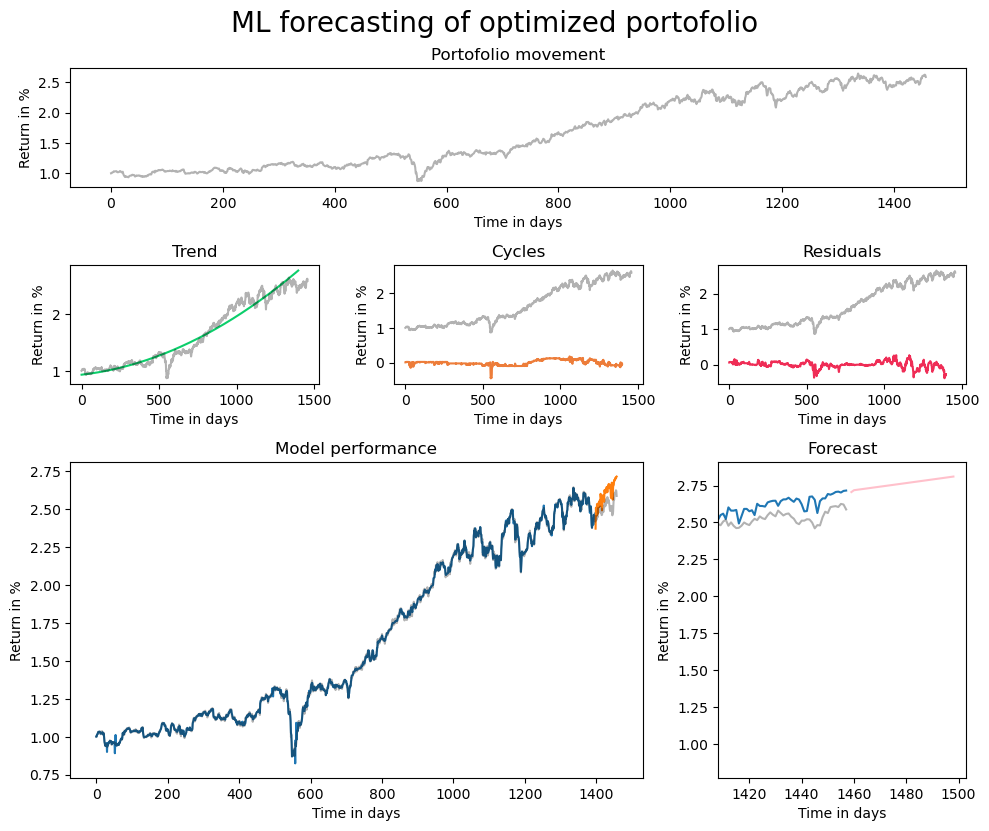

<Figure size 640x480 with 0 Axes>

In [1595]:
pam = portofolio_actual_movement
fig = plt.figure(figsize=(10,10))

ax0 = plt.subplot2grid((5,3),(0,0), colspan=3, rowspan=1)

ax1 = plt.subplot2grid((5,3),(1,0)) 
ax1.plot(y_fit_trend, color='#0CCE6B')

ax2 = plt.subplot2grid((5,3),(1,1))
ax2.plot(y_fit_cyc, color='#ED7D3A')

ax3 = plt.subplot2grid((5,3),(1,2)) 
ax3.plot(y_fit_resid, color='#EF2D56')

ax4 = plt.subplot2grid((5,3),(2,0), colspan=2, rowspan=2)
ax4.plot(final_fit)
ax4.plot(final_pred)


ax5 = plt.subplot2grid((5,3),(2,2), rowspan=2)
ax5.plot(for_idx, forecasts, color='pink')
ax5.plot(final_pred)
ax5.set_xlim(len(y)-50)

axes = [ax0,ax1,ax2,ax3,ax4,ax5]
axes_names = ['Portofolio movement','Trend','Cycles','Residuals', 'Model performance','Forecast']
for i in range(len(axes)):
    axes[i].plot(pam, color='black', alpha=.3)
    axes[i].set_title(axes_names[i])
    axes[i].set_xlabel('Time in days')
    axes[i].set_ylabel('Return in %')

# fig.sub_title('sd')
fig.suptitle('ML forecasting of optimized portofolio', fontsize=20)

fig.tight_layout()
plt.show()
plt.savefig('for_ex.png')

<h1> 9 Summary </h1>
<p> To start I will mention that this programme is under development and has a lot of planned improvments. Now I comment my findings on the forecast plot. It seems like the model has a good ability to capture trend, cycles and residuals of the timeseries. The blue linewhich is the fitted line has a very good fit to actual values. The orange line, the predictions seems to be following the overall trend, however it seems like its overfitting to the actual values. Lastly the pink line, which is the forecast, seems to be udnerfitting. It follows the trend, but has few additional movements in it. This shall be investigate further. A inital thought about this situation is that the models should maybe be finetuned, another forecast strategy might perform better, or something else. </p>
<h3> This programme is in a development phase
